In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from ipynb.fs.full.utility_functions import gen_data_dict, get_data, error_count, opart, show_error_rate

np.random.seed(4)
torch.manual_seed(4)

In [2]:
def normalize_data(data):
    mean = data.mean(dim=0)
    std  = data.std(dim=0)
    norm_data = (data - mean) / std
    return norm_data

In [3]:
# data (inputs)
# chosen_feature = ['std_deviation', 'count', 'sum_diff', 'range_value', 'abs_skewness']
chosen_feature = ['count', 'sum_diff', 'range_value']
data = torch.FloatTensor(pd.read_csv('1_training_data/seq_features.csv').iloc[:, 1:][chosen_feature].to_numpy())
X = normalize_data(data)

In [4]:
# data (targets)
target_df_1 = pd.read_csv('1_training_data/target_lambda_fold1_base_e.csv')
target_df_2 = pd.read_csv('1_training_data/target_lambda_fold2_base_e.csv')

targets_low_1  = torch.FloatTensor(target_df_1.iloc[:, 1:2].to_numpy())
targets_high_1 = torch.FloatTensor(target_df_1.iloc[:, 2:3].to_numpy())
targets_low_2  = torch.FloatTensor(target_df_2.iloc[:, 1:2].to_numpy())
targets_high_2 = torch.FloatTensor(target_df_2.iloc[:, 2:3].to_numpy())

y1_raw = torch.cat((targets_low_1, targets_high_1), dim=1)
y2_raw = torch.cat((targets_low_2, targets_high_2), dim=1)

In [5]:
# filter
idx_fold1 = [idx for idx, item in enumerate(y1_raw) if item[0] > -7 and item[1] < 7]
X1 = X[idx_fold1]
y1 = torch.mean(y1_raw[idx_fold1], axis=1).reshape(-1,1)

idx_fold2 = [idx for idx, item in enumerate(y2_raw) if item[0] > -7 and item[1] < 7]
X2 = X[idx_fold2]
y2 = torch.mean(y2_raw[idx_fold2], axis=1).reshape(-1,1)

In [6]:
print(len(X1), len(y1))
print(len(X2), len(y2))

190 190
313 313


In [10]:
class DLModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size):
        super(DLModel, self).__init__()
        self.hidden_layers = hidden_layers
        self.hidden_size   = hidden_size
        
        # Define input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Define hidden layers
        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers)])
        
        # Define output layer
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Forward pass through input layer
        x = torch.relu(self.input_layer(x))
        
        # Forward pass through hidden layers
        for layer in self.hidden:
            x = torch.relu(layer(x))
        
        # Forward pass through output layer
        x = self.output_layer(x)
        return x

In [9]:
def plot_loss(train_loss, val_loss, train_set, test_set):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    # Find the index of the minimum validation loss
    min_val_loss_index = val_loss.index(min(val_loss))
    min_val_loss = val_loss[min_val_loss_index]
    
    # Mark the minimum validation loss point
    plt.plot(min_val_loss_index + 1, min_val_loss, 'g*', markersize=10, label=f'Min Val epoch: {min_val_loss_index: 3d}')

    plt.title('Train ' + train_set + " Validate " + test_set)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def cv_learn(X, y, n_hiddens, layer_size):
    # Define the number of folds for cross-validation
    kf = KFold(n_splits=2, shuffle=True, random_state=123)

    # loss function
    loss_func = torch.nn.MSELoss()

    # learn best ite
    best_ites = []
    for train_index, val_index in kf.split(X1):
        # Split the data into training and validation sets
        X_train_tensor, X_val_tensor = X[train_index], X[val_index]
        y_train_tensor, y_val_tensor = y[train_index], y[val_index]

        # Define your model, loss, and optimizer
        model = DLModel(input_size=X_train_tensor.shape[1], hidden_layers=n_hiddens, hidden_size=layer_size)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop for the specified number of iterations
        train_losses = []
        val_losses = []
        for _ in range(10000):
            loss1      = loss_func(model(X_train_tensor), y_train_tensor)
            val_loss_1 = loss_func(model(X_val_tensor),   y_val_tensor)
            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()

            train_losses.append(loss1.item())
            val_losses.append(val_loss_1.item())
        
        best_ite_1 = np.argmin(val_losses) + 1
        best_ites.append(best_ite_1)

        # plot
        plot_loss(train_losses, val_losses, train_set='subtrain', test_set='val')

    best_no_ite = int(np.mean(best_ites))
    
    return best_no_ite

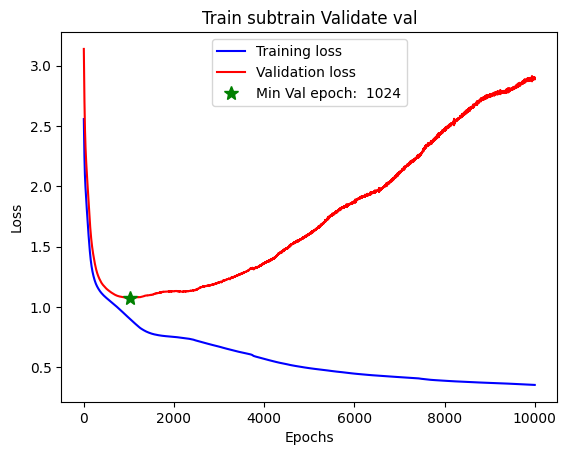

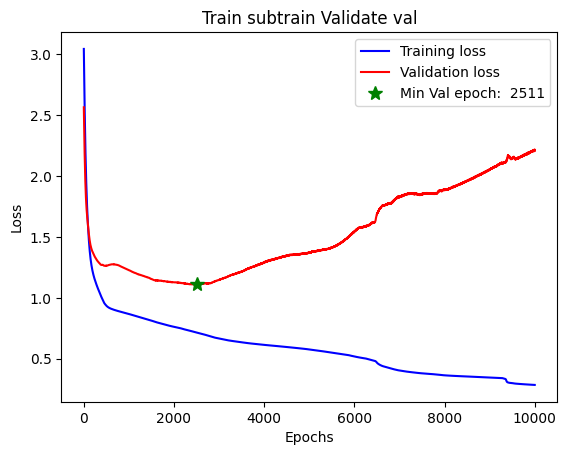

1768

In [11]:
cv_learn(X1, y1, 0, 32)

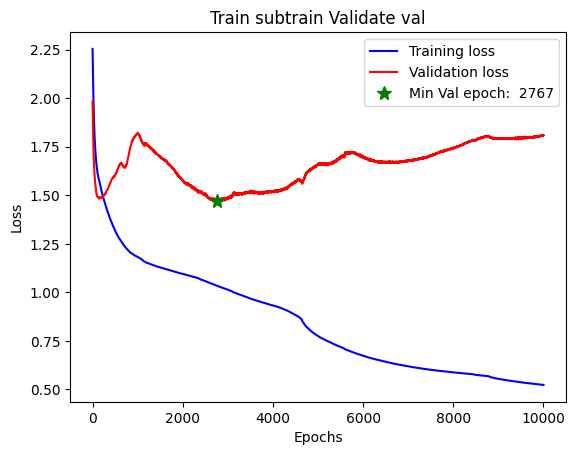

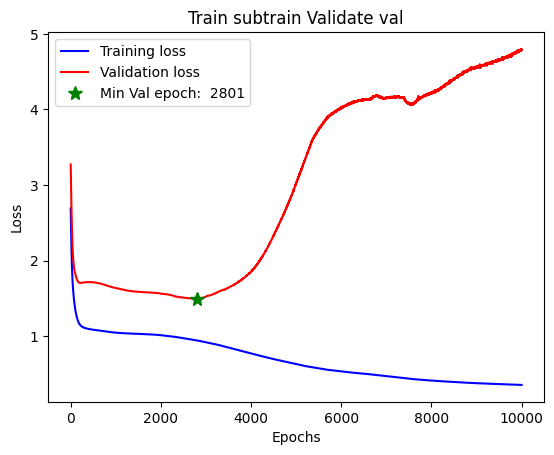

2785

In [12]:
cv_learn(X2, y2, 0, 32)

In [13]:
def train_test_loss_plot(X_train, X_test, y_train, y_test, train_set, test_set):
    # loss function
    loss_func = torch.nn.MSELoss()

    # Define your model, loss, and optimizer
    model = DLModel(input_size=X.shape[1], hidden_layers=0, hidden_size=32)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    for _ in range(10000):
        loss     = loss_func(model(X_train), y_train)
        val_loss = loss_func(model(X_test),  y_test)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
    
    plot_loss(train_losses, val_losses, train_set, test_set)

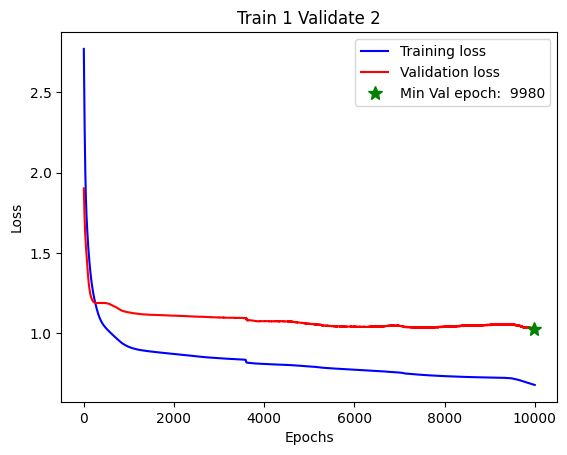

In [14]:
train_test_loss_plot(X_train=X1, X_test=X2, y_train=y1, y_test=y2, train_set='1', test_set='2')

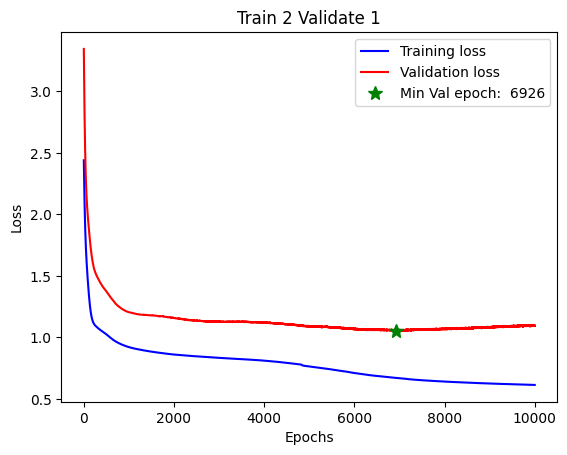

In [15]:
train_test_loss_plot(X_train=X2, X_test=X1, y_train=y2, y_test=y1, train_set='2', test_set='1')

In [16]:
def train_model(X, y, n_hiddens, layer_size, n_ites):
    model = DLModel(input_size=X.shape[1], hidden_layers=n_hiddens, hidden_size=layer_size)
    loss_func = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for _ in range(n_ites):
        # Forward pass
        outputs = model(X)
        
        # Compute the custom loss
        loss = loss_func(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model

In [17]:
def get_df_stat(ldas1, ldas2, seqs, labels):
    header = ['sequenceID', 'log_lambda_test_fold1', 'log_lambda_test_fold2', 'target_1', 'target_2', 'fold_1_total_labels', 'fold_2_total_labels', 'fold_1_fp_errs', 'fold_1_fn_errs', 'fold_1_tp', 'fold_1_tn', 'fold_2_fp_errs', 'fold_2_fn_errs', 'fold_2_tp', 'fold_2_tn']
    rows = []
    for i in range(len(seqs)):
        # generate data
        sequence, neg_start_1, neg_end_1, pos_start_1, pos_end_1, neg_start_2, neg_end_2, pos_start_2, pos_end_2 = get_data(i, seqs=seqs, labels=labels)

        # get total labels
        fold1_total_labels = len(neg_start_1) + len(pos_start_1)
        fold2_total_labels = len(neg_start_2) + len(pos_start_2)

        # run each lambda and record it into csv file
        row  = [seqs[i][0], ldas2[i], ldas1[i], list(y1_raw[i].numpy()), list(y2_raw[i].numpy()), fold1_total_labels, fold2_total_labels]

        chpnt_fold1 = opart(np.exp(ldas2[i]), sequence)
        chpnt_fold2 = opart(np.exp(ldas1[i]), sequence)

        err_1 = error_count(chpnt_fold1, neg_start_1, neg_end_1, pos_start_1, pos_end_1)
        err_2 = error_count(chpnt_fold2, neg_start_2, neg_end_2, pos_start_2, pos_end_2)
        
        for err in [err_1, err_2]:
            row.extend(err[:4])

        rows.append(row)
    
    df = pd.DataFrame(rows, columns=header)
    return df

In [22]:
def try_model(X1, X2, y1, y2, config):
    n_hiddens  = config['n_hiddens']
    layer_size = config['layer_size']

    best_no_ite_1 = cv_learn(X1, y1, n_hiddens, layer_size)
    best_no_ite_2 = cv_learn(X2, y2, n_hiddens, layer_size)

    model1 = train_model(X1, y1, n_hiddens, layer_size, best_no_ite_1)
    model2 = train_model(X2, y2, n_hiddens, layer_size, best_no_ite_2)

    # torch.save(model1.state_dict(), '3_learned_models/2_deep/model1_' + str(n_hiddens) + '_' + str(layer_size) + '.pth')
    # torch.save(model2.state_dict(), '3_learned_models/2_deep/model2_' + str(n_hiddens) + '_' + str(layer_size) + '.pth')

    with torch.no_grad():
        ldas1 = model1(X).numpy().reshape(-1)
        ldas2 = model2(X).numpy().reshape(-1)

    seqs   = gen_data_dict('0_sequences_labels/signals.gz')
    labels = gen_data_dict('0_sequences_labels/labels.gz')
    df = get_df_stat(ldas1, ldas2, seqs, labels)

    return df

In [23]:
# Define the values for n_hiddens and layer_size
n_hiddens_values  = [0, 1, 2, 3]
layer_size_values = [4, 8, 16, 32]

# Create a list of dictionaries
configs = [{'n_hiddens': n, 'layer_size': s} for n in n_hiddens_values for s in layer_size_values]

In [24]:
dfs = Parallel(n_jobs=32)(delayed(try_model)(X1, X2, y1, y2, configs[i]) for i in range(0, len(configs)))

In [25]:
avg_acc = []
for i in range(len(dfs)):
    rate1, rate2,_,_,_,_ = show_error_rate(dfs[i])
    avg_acc.append((rate1 + rate2)/2)
    print("n_hiddens: %1d \t layer_size: %2d \t fold1.test: %5.2f \t fold2.test: %5.2f \t avg_acc: %5.2f" % 
          (configs[i]['n_hiddens'], configs[i]['layer_size'], rate1, rate2, (rate1 + rate2)/2))

n_hiddens: 0 	 layer_size:  4 	 fold1.test: 78.99 	 fold2.test: 75.96 	 avg_acc: 77.48
n_hiddens: 0 	 layer_size:  8 	 fold1.test: 78.72 	 fold2.test: 77.12 	 avg_acc: 77.92
n_hiddens: 0 	 layer_size: 16 	 fold1.test: 79.65 	 fold2.test: 80.58 	 avg_acc: 80.12
n_hiddens: 0 	 layer_size: 32 	 fold1.test: 78.86 	 fold2.test: 79.81 	 avg_acc: 79.33
n_hiddens: 1 	 layer_size:  4 	 fold1.test: 80.32 	 fold2.test: 70.00 	 avg_acc: 75.16
n_hiddens: 1 	 layer_size:  8 	 fold1.test: 79.26 	 fold2.test: 77.31 	 avg_acc: 78.28
n_hiddens: 1 	 layer_size: 16 	 fold1.test: 79.65 	 fold2.test: 79.62 	 avg_acc: 79.63
n_hiddens: 1 	 layer_size: 32 	 fold1.test: 79.92 	 fold2.test: 79.04 	 avg_acc: 79.48
n_hiddens: 2 	 layer_size:  4 	 fold1.test: 80.45 	 fold2.test: 75.96 	 avg_acc: 78.21
n_hiddens: 2 	 layer_size:  8 	 fold1.test: 80.05 	 fold2.test: 80.58 	 avg_acc: 80.32
n_hiddens: 2 	 layer_size: 16 	 fold1.test: 78.99 	 fold2.test: 80.38 	 avg_acc: 79.69
n_hiddens: 2 	 layer_size: 32 	 fold1.test:

In [26]:
df = dfs[np.argmax(avg_acc)]
# df.to_csv('2_learning_record/deep.csv', index=False)

In [27]:
show_error_rate(df)

(80.05319148936171, 81.34615384615384, 752, 520, 150, 97)